In [9]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/Joao/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package stopwords to /Users/Joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


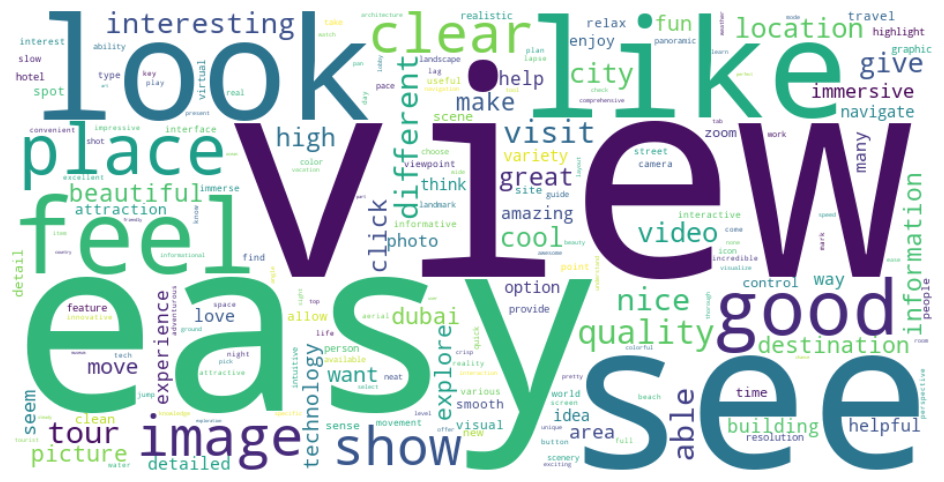

Total words before filtering: 5470
Words used in word cloud: 2480
Words removed by filters: 2990
Percentage of words removed: 54.66%


In [3]:
# Import necessary libraries
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

# Download stopwords from NLTK
nltk.download('stopwords')

# Load English stopwords and SpaCy language model
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

# Load the Excel file and preprocess text data
df = pd.read_excel('raw_data.xlsx')
texts = df['VR quality'].dropna().astype(str).tolist()
raw_text = " ".join(texts)

# Process text with SpaCy NLP pipeline
doc = nlp(raw_text.lower())

# Define a set of low-value or "nettlesome" words to exclude
nettlesome_words = {
    "thing", "stuff", "say", "use", "get", "really", "well",
    "also", "may", "could", "would", "one", "two", "lot"
}

# Specify parts of speech to keep
important_pos = {"NOUN", "ADJ", "VERB"}

# Filter and lemmatize tokens
tokens = [
    token.lemma_ for token in doc
    if (
        token.is_alpha and
        token.lemma_ not in stop_words and
        len(token.lemma_) > 2 and
        token.lemma_ not in nettlesome_words and
        token.pos_ in important_pos
    )
]

# Count word frequencies
freq = Counter(tokens)

# Save frequency data to CSV in current folder
freq_df = pd.DataFrame(freq.items(), columns=['Word', 'Frequency'])
freq_df = freq_df.sort_values(by='Frequency', ascending=False)
freq_df.to_csv('vr_quality_word_frequencies.csv', index=False)

# Create compact grid layout for frequency table image
sorted_items = sorted(freq.items(), key=lambda x: -x[1])
num_pairs_per_row = 3  # Adjust for more or fewer columns
num_columns = num_pairs_per_row * 2
num_rows = math.ceil(len(sorted_items) / num_pairs_per_row)

grid_data = []
for row_idx in range(num_rows):
    row = []
    for col in range(num_pairs_per_row):
        idx = row_idx + col * num_rows
        if idx < len(sorted_items):
            word, freq_val = sorted_items[idx]
            row.extend([word, freq_val])
        else:
            row.extend(["", ""])
    grid_data.append(row)

col_labels = []
for i in range(num_pairs_per_row):
    col_labels.extend([f"Word", f"Freq"])

df_grid = pd.DataFrame(grid_data, columns=col_labels)

# Save compact frequency table image in current folder
fig, ax = plt.subplots(figsize=(12, num_rows * 0.4 + 1))
ax.axis('off')
tbl = ax.table(cellText=df_grid.values, colLabels=df_grid.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)
plt.savefig('vr_quality_word_frequencies_clean_grid.png', bbox_inches='tight', dpi=300)
plt.close()

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(freq)

# Save word cloud image in current folder
wordcloud.to_file("vr_quality_wordcloud.png")

# Display word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Calculate and print filtering stats
total_words_all = [token.lemma_ for token in doc if token.is_alpha]
used_words = tokens
num_total = len(total_words_all)
num_used = len(used_words)
num_removed = num_total - num_used

print(f"Total words before filtering: {num_total}")
print(f"Words used in word cloud: {num_used}")
print(f"Words removed by filters: {num_removed}")
print(f"Percentage of words removed: {num_removed / num_total:.2%}")
